In [1]:
import sys, types
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os, re
import numpy as np
import pandas as pd
from PIL import Image
import anndata
from pathlib import Path
from scipy.ndimage import binary_erosion, binary_dilation

In [2]:
data_dir = Path("cellpose_transcripts_opposite_lyso")
all_files = sorted(data_dir.glob("*.csv"))
dfs = [pd.read_csv(f, index_col=0) for f in all_files]

combined_df = pd.concat(dfs, axis=0)

In [3]:
top4 = ['ID2-4', 'SOX5-3', 'NFIB-2', 'ID2-2']
sgRNA_genes = [gene for gene in combined_df.columns if '-' in gene and not 'HLA' in gene]
sgRNA_cols = [
    col for col in sgRNA_genes
    if col not in top4
]

gene_names = sorted({col.split("-", 1)[0] for col in sgRNA_cols})
perturb_df = pd.DataFrame(index=combined_df.index, columns=gene_names, dtype="object")
for gene in gene_names:
    matching_cols = [col for col in sgRNA_cols if col.startswith(gene + "-")]
    if not matching_cols:
        continue

    sub_df = combined_df[matching_cols]
    any_positive = (sub_df > 0).any(axis=1)
    perturb_df[gene] = any_positive.map({True: "perturbed", False: "unperturbed"})

In [4]:
cell_profiler_metrics = pd.read_csv("path/to/cellprofiler/output/morphometrics/3_cellprofiler/output/MyExpt_SomaAndNeuritesMerged.csv")

cell_profiler_metrics_filtered = cell_profiler_metrics[cell_profiler_metrics['AreaShape_Area']>1000]
cell_profiler_metrics_filtered = cell_profiler_metrics_filtered[cell_profiler_metrics_filtered['AreaShape_Eccentricity']>0.4]

cell_profiler_metrics_filtered['cell_id'] = (
    cell_profiler_metrics_filtered['ImageNumber'].astype(str)
    + '_'
    + cell_profiler_metrics_filtered['ObjectNumber'].astype(str)
)


In [5]:
cell_profiler_soma = pd.read_csv("path/to/cellprofiler/output/morphometrics/3_cellprofiler/output/MyExpt_soma.csv")

cell_profiler_soma['cell_id'] = (
    cell_profiler_soma['ImageNumber'].astype(str)
    + '_'
    + cell_profiler_soma['ObjectNumber'].astype(str)
)


In [6]:
cell_profiler_soma_filtered = cell_profiler_soma[cell_profiler_soma['cell_id'].isin(cell_profiler_metrics_filtered['cell_id'])]


In [7]:
perturb_df_filtered = perturb_df[perturb_df.index.isin(cell_profiler_metrics_filtered['cell_id'])]


In [8]:
neg_ctrl_only = perturb_df_filtered.index[
    (perturb_df_filtered["Negative_control"] == "perturbed") &
    (perturb_df_filtered["ONECUT1"]        != "perturbed")
].tolist()

onecut1_only  = perturb_df_filtered.index[
    (perturb_df_filtered["ONECUT1"]        == "perturbed") &
    (perturb_df_filtered["Negative_control"] != "perturbed")
].tolist()

In [14]:
sparse_medium_fov = ['62','67','93','101','104','110','119','131','132','134','164','194','209','227','228',
                     '242','248','264','310','312','318','396','404','428','438'
                    ]
sparse_fov = ['62','227','242','248','264','318','396','404','428','438']
sparse_medium_fov = sparse_medium_fov +['1', '16', '17', '28', '29', '31', '32', '42', '43', '46', '47', 
                                        '57', '58', '61', '72', '73', '76', '103', '118', '121', '122', 
                                        '123', '133', '136', '148', '151', '152', '153', '163', '165', '166', 
                                        '178', '180', '181', '182', '193', '105', '196', '197']

In [15]:
onecut1_only_sparse_medium = []
onecut1_only_sparse = []
for cell_id in onecut1_only:
    if cell_id.split('_')[0] in sparse_medium_fov:
        onecut1_only_sparse_medium.append(cell_id)
        if cell_id.split('_')[0] in sparse_fov:
            onecut1_only_sparse.append(cell_id)

In [18]:
len(onecut1_only_sparse_medium)

272

In [16]:
neg_ctrl_only_sparse_medium = []
neg_ctrl_only_sparse = []
for cell_id in neg_ctrl_only:
    if cell_id.split('_')[0] in sparse_medium_fov:
        neg_ctrl_only_sparse_medium.append(cell_id)
        if cell_id.split('_')[0] in sparse_fov:
            neg_ctrl_only_sparse.append(cell_id)

In [19]:
len(neg_ctrl_only_sparse_medium)

171

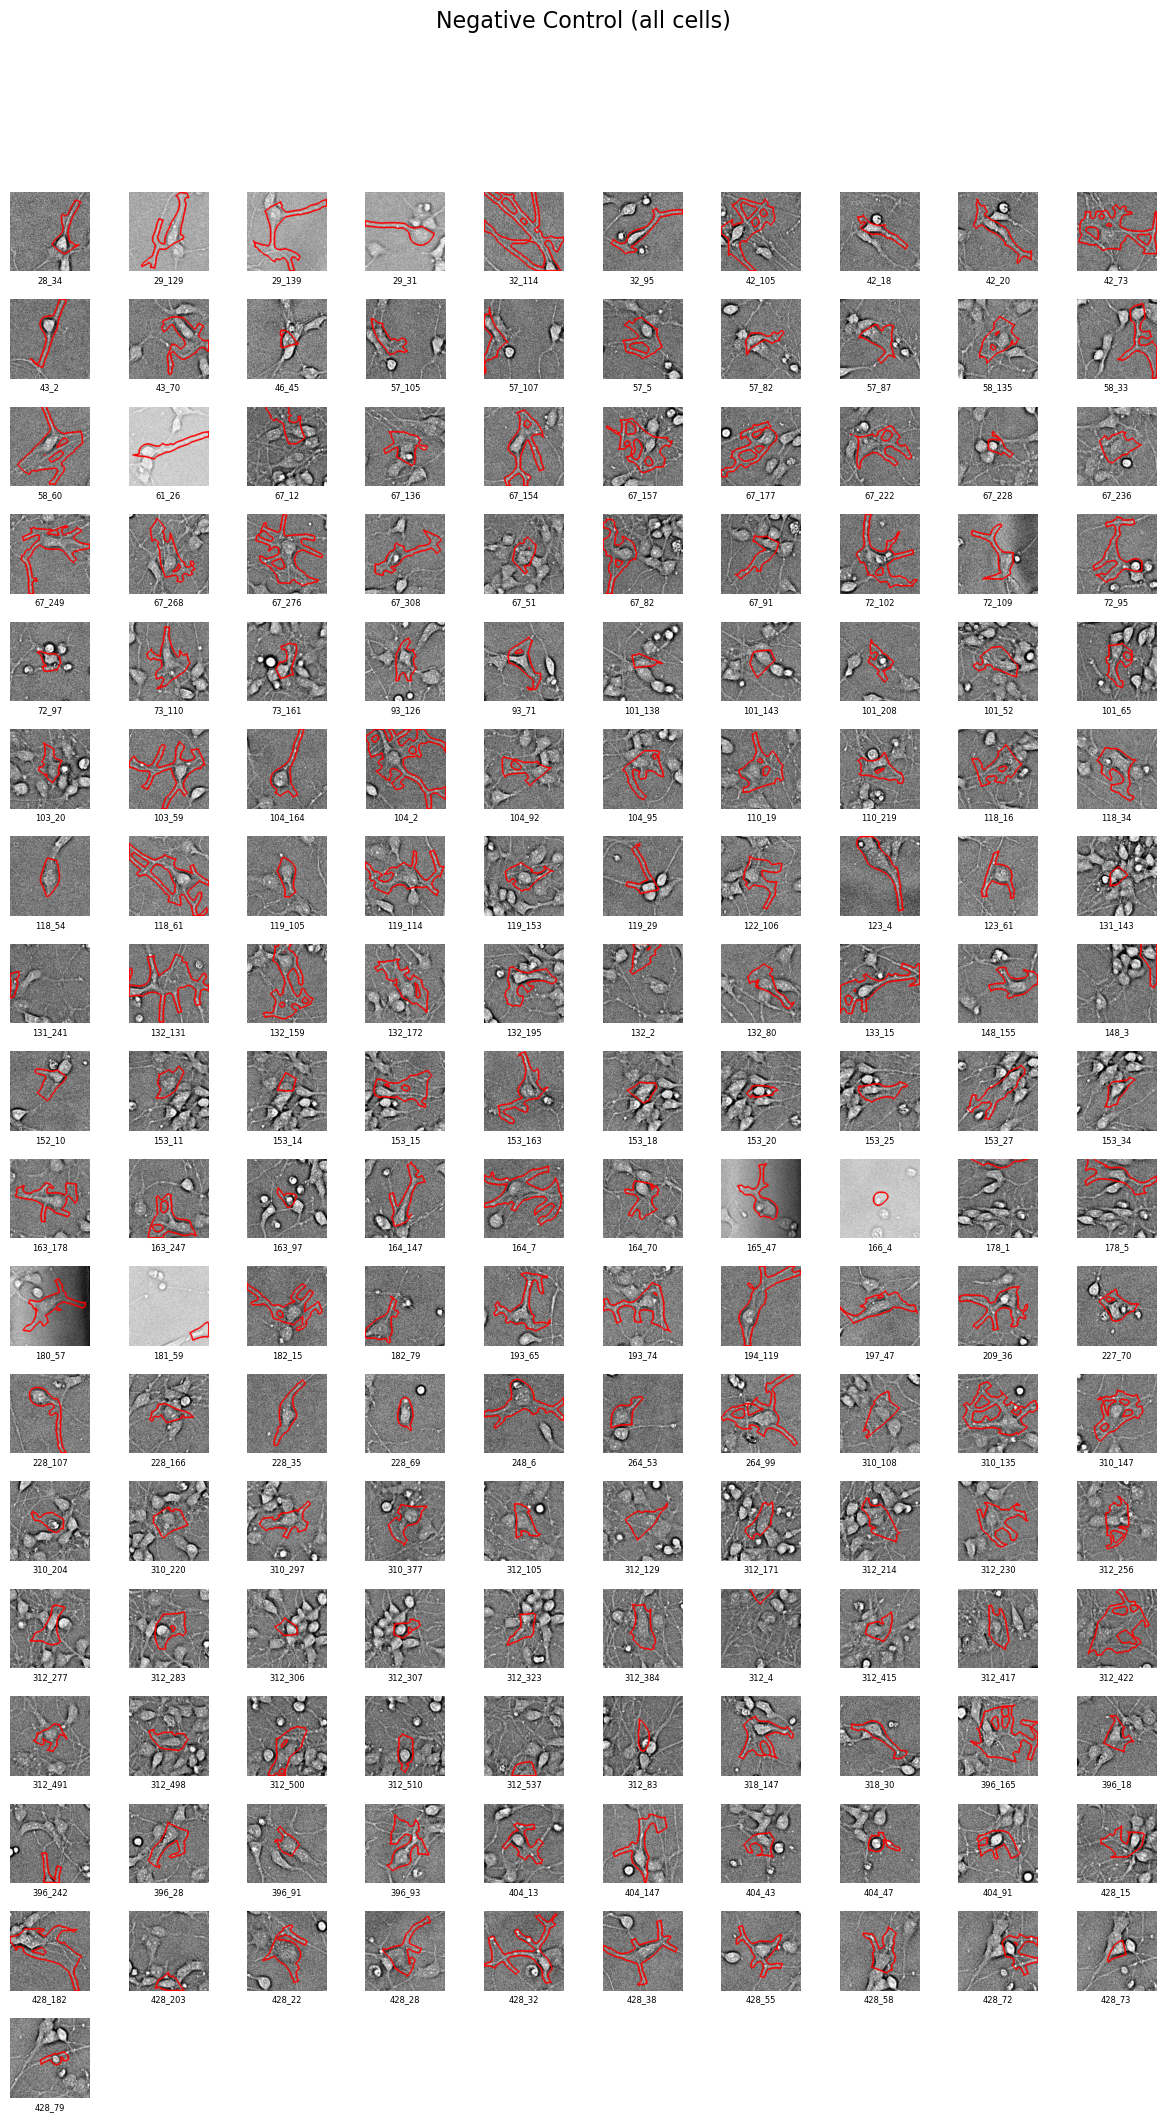

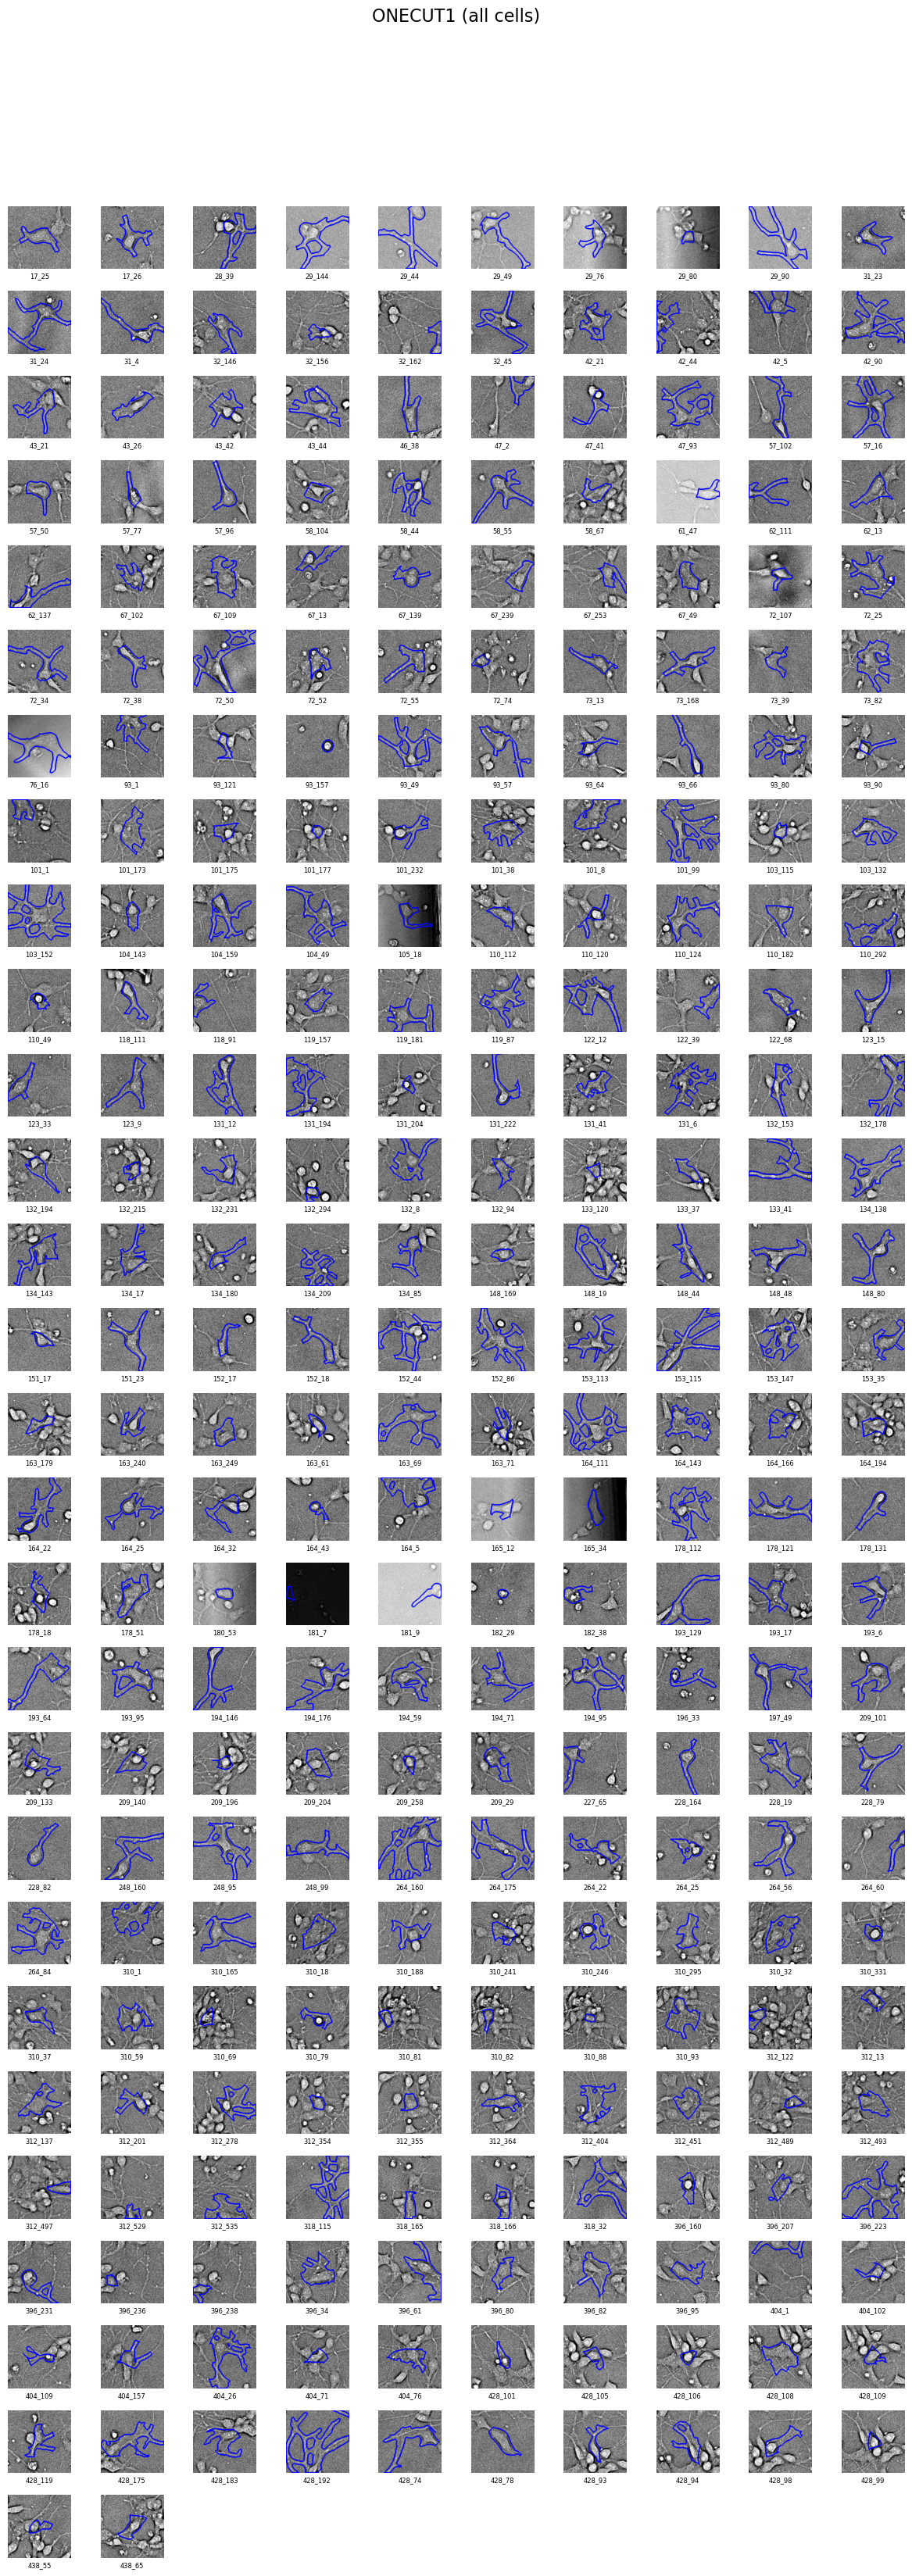

Saved 443 images to 'cell_morph_figures_V2/'


In [17]:
vis_dir = (
    "path/to/cellprofiler/output/"
    "morphometrics/3_cellprofiler/output/visualizations"
)
raw_base = (
    "path/BF/channel/images"
)
HALF = 128
OUTLINE_THICKNESS = 2
out_dir = "cell_morph_figures_V2"

os.makedirs(out_dir, exist_ok=True)

def parse_cell_id(cid):
    fov, mid = cid.split("_")
    return int(fov), int(mid)

def normalize(img, low_pct=1, high_pct=99):
    lo, hi = np.percentile(img, (low_pct, high_pct))
    img = np.clip(img, lo, hi)
    img = (img - lo) / (hi - lo)
    return (img * 255).astype(np.uint8)

def get_all_crops_with_thick_outline(cell_list, color):
    crops, ids = [], []
    for cid in cell_list:
        fov, mask_id = parse_cell_id(cid)
        mask_path = os.path.join(
            vis_dir,
            f"W0001F{fov:04d}T0001Z001C1SomaNeuriteUint16.tiff"
        )
        mask_im = np.array(Image.open(mask_path))
        ys, xs = np.where(mask_im == mask_id)
        if len(xs) == 0:
            continue

        cx, cy = int(xs.mean()), int(ys.mean())

        field = f"Field{fov:04d}"
        raw_path = os.path.join(
            raw_base, field,
            f"W0001F{fov:04d}T0001Z001C1.tif"
        )
        raw_u8 = normalize(np.array(Image.open(raw_path)))

        x0 = max(cx - HALF, 0)
        y0 = max(cy - HALF, 0)
        x1 = min(x0 + 2*HALF, raw_u8.shape[1])
        y1 = min(y0 + 2*HALF, raw_u8.shape[0])
        x0 = max(x1 - 2*HALF, 0)
        y0 = max(y1 - 2*HALF, 0)

        raw_crop  = raw_u8[y0:y1, x0:x1]
        mask_crop = mask_im[y0:y1, x0:x1]

        rgb = np.stack([raw_crop]*3, axis=-1)
        mask_bin = (mask_crop == mask_id)
        outline  = mask_bin & (~binary_erosion(mask_bin))
        thick    = binary_dilation(outline, iterations=OUTLINE_THICKNESS)
        rgb[thick] = color

        crops.append(rgb)
        ids.append(cid)

    return crops, ids

def plot_montage_with_ids(crops, ids, title, ncol=10):
    n = len(crops)
    nrow = (n + ncol - 1) // ncol
    fig, axes = plt.subplots(
        nrow, ncol,
        figsize=(ncol * 1.2, nrow * 1.2),
        squeeze=False
    )
    fig.suptitle(title, fontsize=16)

    for ax, crop, cid in zip(axes.flatten(), crops, ids):
        ax.imshow(crop)
        ax.set_xticks([]); ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.text(
            0.5, -0.05, cid,
            transform=ax.transAxes,
            ha="center", va="top",
            fontsize=6
        )

    for ax in axes.flatten()[n:]:
        ax.set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

neg_crops,    neg_ids    = get_all_crops_with_thick_outline(neg_ctrl_only_sparse_medium,    color=(255, 0,   0))
onecut_crops, onecut_ids = get_all_crops_with_thick_outline(onecut1_only_sparse_medium,     color=(0,   0, 255))

plot_montage_with_ids(neg_crops,    neg_ids,    "Negative Control (all cells)")
plot_montage_with_ids(onecut_crops, onecut_ids, "ONECUT1 (all cells)")

for crop, cid in zip(neg_crops, neg_ids):
    im = Image.fromarray(crop)
    fname = f"{cid}_neg.png"
    im.save(os.path.join(out_dir, fname), format="PNG", compress_level=0)

for crop, cid in zip(onecut_crops, onecut_ids):
    im = Image.fromarray(crop)
    fname = f"{cid}_onecut1.png"
    im.save(os.path.join(out_dir, fname), format="PNG", compress_level=0)

print(f"Saved {len(neg_crops)+len(onecut_crops)} images to '{out_dir}/'")
